## Problem 1: Linear regression on a simple dataset

### Q1.

In [1]:
import numpy as np
import pandas as pd

csv_path = "Concrete_Data_Yeh.csv"

df = pd.read_csv(csv_path)

# target is csMPa
y_col = [c for c in df.columns if c.lower() == "csmpa"][0]
X_cols = [c for c in df.columns if c != y_col]

# N x 8 features
X = df[X_cols].to_numpy(dtype=np.float64)

# N x 1 target
y = df[[y_col]].to_numpy(dtype=np.float64)

# add bias column of ones → N x 9
Xb = np.hstack([np.ones((X.shape[0], 1)), X])

beta_hat = np.linalg.inv(Xb.T @ Xb) @ (Xb.T @ y)
np.set_printoptions(suppress=True)
beta_hat = beta_hat.ravel()
print("beta_hat:", beta_hat)

# compute MSE
y_pred = Xb @ beta_hat.reshape(-1, 1)

mse = float(np.mean((y - y_pred)**2))
mse

beta_hat: [-23.33121358   0.11980433   0.10386581   0.08793432  -0.14991842
   0.2922246    0.01808621   0.02019035   0.11422207]


107.19723607486016

### Q2.

In [2]:
# Load data from the data file
df = pd.read_csv("Concrete_Data_Yeh.csv")

# Features (in file order) and target
features = ["cement","slag","flyash","water","superplasticizer",
            "coarseaggregate","fineaggregate","age"]
target = "csMPa"

X = df[features].to_numpy(dtype=np.float64)
y = df[[target]].to_numpy(dtype=np.float64)

# 75/25 split (fixed seed for reproducibility)
rng = np.random.RandomState(42)
N = len(df)
perm = rng.permutation(N)
n_train = int(0.75 * N)
tr, va = perm[:n_train], perm[n_train:]
y_tr, y_va = y[tr], y[va]

def add_bias(A): return np.hstack([np.ones((A.shape[0], 1)), A])
def fit_ols(Xb, y): return np.linalg.inv(Xb.T @ Xb) @ (Xb.T @ y)
def mse(a, b): return float(np.mean((a - b)**2))

mse_val = {}
for i in (7, 8, 9):
    k = i - 1
    feats = features[:k]
    Xtr_b = add_bias(df.loc[tr, feats].to_numpy(np.float64))
    Xva_b = add_bias(df.loc[va, feats].to_numpy(np.float64))
    beta  = fit_ols(Xtr_b, y_tr)
    yhat  = Xva_b @ beta
    mse_val[i] = mse(y_va, yhat)

print("Validation MSE by i (coef count incl. bias):", mse_val)


Validation MSE by i (coef count incl. bias): {7: 157.4303183183509, 8: 157.81350398874218, 9: 103.96737099360246}


## Answer to Problem 1 - Q2:

### On this split, i=7 → 157.43, i=8 → 157.81, i=9 → 103.97. Models with more variables do not always yield lower validation MSE; here the full model (i=9) performed best, while adding just one extra feature from i=7 to i=8 did not improve validation error.

## Problem 2: Multinomial Logistic regression from pre-trained feature extractor

**Step 3 — Derive the gradients for softmax (multinomial logistic) regression**

Let a batch have size $B$. Features $H\in\mathbb{R}^{B\times k}$, one-hot labels $Y\in\mathbb{R}^{B\times C}$.
Parameters $W\in\mathbb{R}^{k\times C}$, $b\in\mathbb{R}^{C}$.
Logits and probabilities (row-wise softmax):
$$Z = H W + \mathbf{1}\, b^{\top} \in \mathbb{R}^{B\times C},
\qquad
P = \text{softmax}(Z) \;\;(\text{row-wise}).$$

Mean cross-entropy:
$$L = -\frac{1}{B}\sum_{i=1}^{B}\sum_{c=1}^{C} y_{ic}\,\log p_{ic}.$$
 
For a single row $z_i\in\mathbb{R}^C$ with $p_{ic}=\frac{e^{z_{ic}}}{\sum_{r}e^{z_{ir}}}$ and one-hot $y_i$,
$$\ell_i = -\sum_{c} y_{ic}\,\log p_{ic}.$$

Using $\log p_{ic} = z_{ic} - \log\left(\sum_r e^{z_{ir}}\right)$,
$$\frac{\partial \log p_{ic}}{\partial z_{ir}}
= \delta_{cr} - p_{ir}
\quad\Rightarrow\quad
\frac{\partial \ell_i}{\partial z_{ir}}
= -\sum_{c} y_{ic}\,(\delta_{cr}-p_{ir})
= p_{ir} - y_{ir}.$$

Stacking all examples,
$$\boxed{\;\frac{\partial L}{\partial Z} = \frac{1}{B}(P - Y)\;} \;\in\; \mathbb{R}^{B\times C}.$$

Since $Z = HW + \mathbf{1}\, b^{\top}$,
$$dZ = H\,dW + \mathbf{1}\, (db)^{\top}.$$

With the Frobenius inner product $\langle A,B\rangle=\text{tr}(A^{\top} B)$ and $G := \frac{\partial L}{\partial Z}$,
\begin{align}
dL
&= \left\langle \frac{\partial L}{\partial Z},\, dZ \right\rangle
 = \langle G,\, H\,dW + \mathbf{1}\,(db)^{\top} \rangle \\
&= \langle H^{\top} G,\, dW \rangle \;+\; \langle G^{\top} \mathbf{1},\, db \rangle.
\end{align}

Therefore,
$$\boxed{\;\frac{\partial L}{\partial W} = H^{\top} G
= \frac{1}{B}\, H^{\top} (P - Y)\;} \;\in\; \mathbb{R}^{k\times C},$$
$$\boxed{\;\frac{\partial L}{\partial b} = G^{\top} \mathbf{1}
= \frac{1}{B}\, (P - Y)^{\top} \mathbf{1}\;} \;\in\; \mathbb{R}^{C}.$$

For one pair $(h,y)$ with $p=\text{softmax}(W^{\top} h + b)$,
$$\boxed{\;\frac{\partial \ell}{\partial W} = h\,(p - y)^{\top},\qquad
\frac{\partial \ell}{\partial b} = p - y.\;}$$

These are exactly the gradients implemented in the training loop.

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Import the extractor class and alias it as Encoder for compatibility
from pretrained_model.Encoder import extractor as Encoder

torch.manual_seed(0)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

encoder = Encoder().to(device)
state = torch.load("pretrained_model/feature_extractor_weights.pth", map_location=device)
encoder.load_state_dict(state)
encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False

In [4]:
# MNIST: train = training set, test = validation set
tfm = transforms.ToTensor()
train_ds = datasets.MNIST(root="./data", train=True,  download=True, transform=tfm)
val_ds   = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=False)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)

def extract_features(dloader, enc, dev):
    H_list, y_list = [], []
    with torch.no_grad():
        for x, y in dloader:
            x = x.to(dev)
            h = enc(x)
            H_list.append(h.cpu())
            y_list.append(y)
    H = torch.cat(H_list, dim=0)
    y = torch.cat(y_list, dim=0)
    return H, y

H_tr, y_tr = extract_features(train_loader, encoder, device)
H_va, y_va = extract_features(val_loader,   encoder, device)

k = H_tr.shape[1]
C = 10

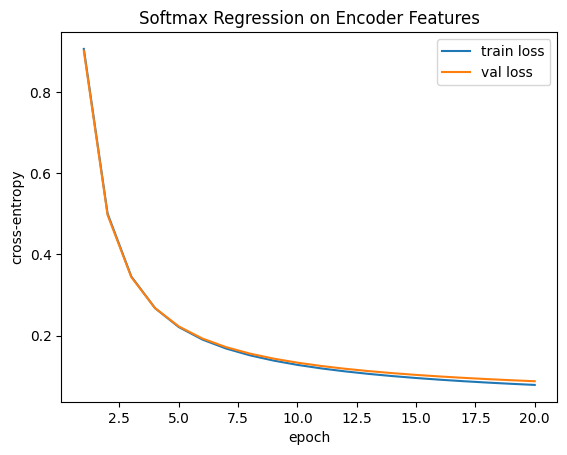

In [5]:
def softmax_logits(H, W, b):
    Z = H @ W + b
    Z = Z - Z.max(dim=1, keepdim=True).values
    P = torch.exp(Z)
    P = P / P.sum(dim=1, keepdim=True)
    return Z, P

def ce_loss(H, y, W, b):
    _, P = softmax_logits(H, W, b)
    Y = F.one_hot(y, num_classes=C).float()
    return -(Y * (P.clamp_min(1e-12)).log()).sum(dim=1).mean()

# DataLoaders over precomputed features
train_feat_loader = DataLoader(TensorDataset(H_tr, y_tr), batch_size=256, shuffle=True)

# Initialize parameters
W = torch.zeros(k, C, device=device)
b = torch.zeros(C, device=device)

# Hyperparameters
epochs = 20
lr     = 0.001

train_losses, val_losses = [], []

for epoch in range(epochs):
    # SGD updates (matrix ops only)
    for Hb, yb in train_feat_loader:
        Hb = Hb.to(device)
        yb = yb.to(device)
        B  = Hb.size(0)

        Z, P = softmax_logits(Hb, W, b)
        Y = F.one_hot(yb, num_classes=C).float()

        # dL/dZ = (P - Y)/B
        dZ = (P - Y) / B
        dW = Hb.t() @ dZ
        db = dZ.sum(dim=0)

        # SGD step
        W -= lr * dW
        b -= lr * db

    # record full-dataset train/val loss each epoch
    with torch.no_grad():
        tr_loss = ce_loss(H_tr.to(device), y_tr.to(device), W, b).item()
        va_loss = ce_loss(H_va.to(device), y_va.to(device), W, b).item()
    train_losses.append(tr_loss)
    val_losses.append(va_loss)

# Plot training & validation loss (single chart, two lines)
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label="train loss")
plt.plot(range(1, epochs+1), val_losses,   label="val loss")
plt.xlabel("epoch")
plt.ylabel("cross-entropy")
plt.legend()
plt.title("Softmax Regression on Encoder Features")
plt.show()

## Problem 3: Transformation from a uniform distribution

Let $U_1, U_2 \overset{\text{i.i.d.}}{\sim}\text{Unif}(0,1)$. Set
$$\Theta = 2\pi U_1, \qquad R=\sqrt{-2\ln U_2}.$$

Because $U_1$ and $U_2$ are independent, $\Theta$ and $R$ are independent.  
Since $\Theta\sim\text{Unif}[0,2\pi)$,
$$f_{\Theta}(\theta)=\frac{1}{2\pi}, \qquad \theta\in[0,2\pi).$$

To get $f_R$, define $V=-2\ln U_2$. For $v\ge 0$,
\begin{align}
\mathrm{Pr}(V\le v)
&=\mathrm{Pr}(-2\ln U_2\le v)\\
&=\mathrm{Pr}\left(U_2\ge e^{-v/2}\right)\\
&=1-e^{-v/2},
\end{align}
so
$$f_V(v)=\frac{1}{2}e^{-v/2}, \qquad v\ge 0.$$

With $R=\sqrt{V}$ we have $v=r^2$ and $\frac{dv}{dr}=2r$. Hence, for $r\ge 0$,
\begin{align}
f_R(r)
&= f_V(r^2)\,\frac{dv}{dr}\\
&= \left(\frac{1}{2}e^{-r^2/2}\right)(2r)\\
&= r\,e^{-r^2/2}.
\end{align}
Therefore the joint density of $(R,\Theta)$ is
$$f_{R,\Theta}(r,\theta)=f_R(r)\,f_{\Theta}(\theta)
=\frac{1}{2\pi}\, r\, e^{-r^2/2},
\qquad r\ge 0,\;\theta\in[0,2\pi).$$

Define
$$Z_1=R\cos\Theta,\qquad Z_2=R\sin\Theta .$$

The inverse (polar $\to$ Cartesian) map is
$$r=\sqrt{z_1^2+z_2^2}, \qquad \theta=\text{atan2}(z_2,z_1).$$

The Jacobian determinant of the inverse is
$$\left|\frac{\partial(r,\theta)}{\partial(z_1,z_2)}\right|=\frac{1}{r}
\quad\text{so}\quad
dz_1\,dz_2 = r\,dr\,d\theta .$$

Therefore, for any $(z_1,z_2)\in\mathbb{R}^2$,
\begin{align}
f_{Z_1,Z_2}(z_1,z_2)
&= f_{R,\Theta}(r,\theta)\,
\left|\frac{\partial(r,\theta)}{\partial(z_1,z_2)}\right| \\
&= \left(\frac{1}{2\pi}\, r\, e^{-r^2/2}\right)\left(\frac{1}{r}\right)\\
&= \frac{1}{2\pi} \exp\left(-\frac{z_1^2+z_2^2}{2}\right),
\end{align}
since $r^2=z_1^2+z_2^2$.

The joint density factors:
$$f_{Z_1,Z_2}(z_1,z_2)
= \frac{1}{\sqrt{2\pi}}e^{-z_1^2/2}\;
  \frac{1}{\sqrt{2\pi}}e^{-z_2^2/2}.$$

Hence $Z_1\sim\mathcal{N}(0,1)$ and $Z_2\sim\mathcal{N}(0,1)$, and
$$f_{Z_1,Z_2}(z_1,z_2)=f_{Z_1}(z_1)\,f_{Z_2}(z_2),$$
which shows independence.

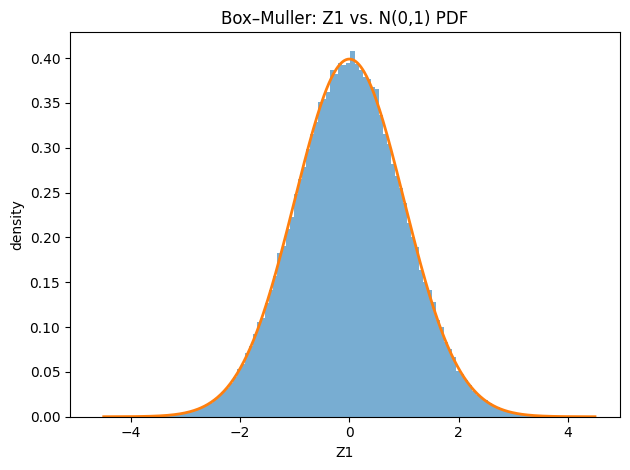

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Sample independent uniforms
n = 200_000
U1 = np.random.rand(n)
U2 = np.random.rand(n)

# Box–Muller transform
theta = 2 * np.pi * U1
R = np.sqrt(-2.0 * np.log(1.0 - U2))
Z1 = R * np.cos(theta)

# Plot: histogram of Z1 with N(0,1) pdf overlay
x = np.linspace(-4.5, 4.5, 601)
phi = (1.0 / np.sqrt(2.0 * np.pi)) * np.exp(-0.5 * x**2)

plt.figure()
plt.hist(Z1, bins=120, density=True, alpha=0.6)
plt.plot(x, phi, linewidth=2)
plt.xlabel("Z1")
plt.ylabel("density")
plt.title("Box–Muller: Z1 vs. N(0,1) PDF")
plt.tight_layout()
plt.show()